# Assessment of Ocean Colour temporal stability for ecological studies
## Use case: *Assess potential decrease in marine fish stock due to oceanic desertification*
## Quality assessment question: 
**Does the consistency of chlorophyll-a and remote sensing reflectance get affected by the succession of satellite sensors over time?**

The Ocean Colour dataset version 6.0, as released by the Climate Change Initiative (CCI) of the European Space Agency (ESA) [[1]](https://doi.org/10.3390/s19194285), includes the Essential Climate Variables (ECVs), mass concentration of chlorophyll-a and remote sensing reflectance (Rrs) for six wavelengths from October 1997 to present [[2]](https://datastore.copernicus-climate.eu/documents/satellite-ocean-colour/v6.0/WP2-FDDP-2022-04_C3S2-Lot3_PUGS-of-v6.0-OceanColour-product_v1.1_FINAL.pdf).  
Chlorophyll-a concentration is typically used as proxy for algal biomass and fisheries production [[3]](https://doi.org/10.4319/lo.1997.42.7.1479) [[4]](https://doi.org/10.1371/journal.pone.0028945) and is derived through specific algorithms  by using remote sensing reflectance (Rrs) [[5]](https://datastore.copernicus-climate.eu/documents/satellite-ocean-colour/v6.0/WP2-FDDP-2022-04_C3S2-Lot3_ATBD-of-v6.0-OceanColour-product_v1.1_FINAL.pdf).  
The dataset combines measurements carried out by six satellite sensors [[2]](https://datastore.copernicus-climate.eu/documents/satellite-ocean-colour/v6.0/WP2-FDDP-2022-04_C3S2-Lot3_PUGS-of-v6.0-OceanColour-product_v1.1_FINAL.pdf): SeaWiFS, MERIS, MODIS-Aqua, VIIRS, OLCI-3A and OLCI-3B. No sensor was operational over the whole temporal coverage of the datasets and only OLCI-3A and OLCI-3B are still acquiring.  
Here, the goal is to assess if the stability of Ocean Colour time series is affected by the transition of different satellite sensors over time.

## Quality assessment statement
The ESA CCI Ocean Colour dataset version 6.0:  
* provides a time consistent record of remote sensing reflectance at 443 and 560 nm, and derived chlorophyll-a concentrations, which is not affected by the succession of different satellite sensors. However, data prior to March 2002 should be carefully evaluated.  
* would overestimate chlorophyll-a concentrations before March 2002, especially in more productive oceanic regions.  
* indicates decreasing chlorophyll-a trends at both global and regional scales.

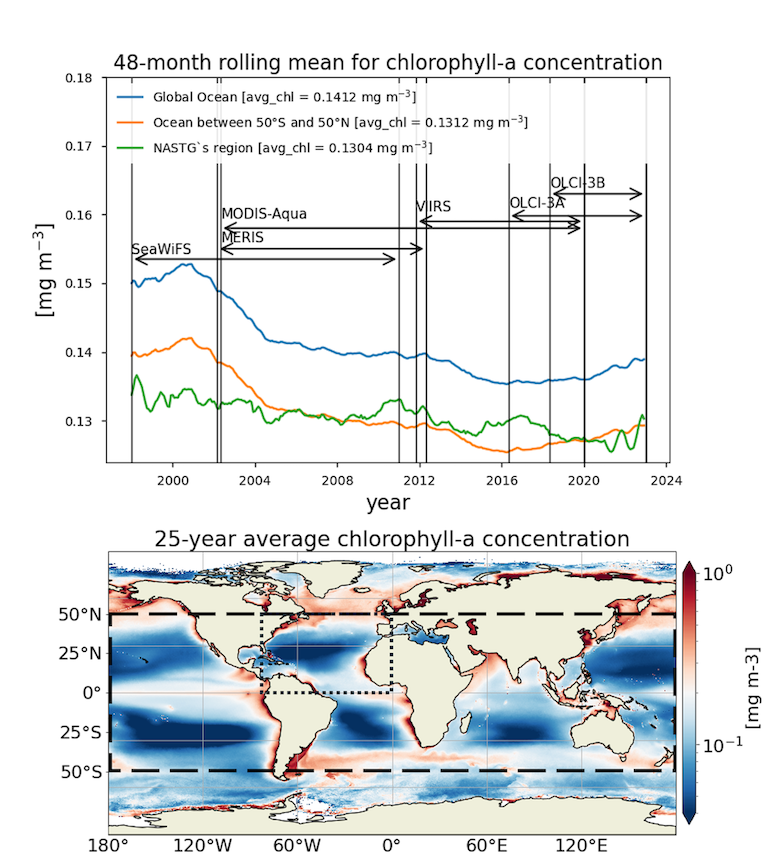
<center>Fig.1 The top panel shows the 48-month rolling mean of chlorophyll-a concentrations calculated in the three regions selected for the analysis, as well as the name and duration of each satellite mission used to produce the dataset. Mean chlorophyll-a concentrations are also provided in the legend. The lower panel shows a global map of the 25-year average chlorophyll-a concentration. Dashed and dotted boxes on the map indicate the oceanic region between latitudes 50°S-50°N and the NASTG's region, respectively. </center>

## Methodology
 
The analysis and results are detailed in the sections below:
1. [Choose the data to use and setup the code](#id1)
   * Import required packages
   * Define parameters to be analysed (time period, variables, regions) and data request
2. [Area average function and data retrieval](#id2)
   * Area average function
   * Retrieve daily averages for the selected variables, time period and regions.
3. [Plot and statistics functions](#id3)
   * Compute statistics and define plot function
   * Define satellite missions
4. [Plot and describe results](#id4)
   * Display results 
   * Discussion

## Analysis and results
<a id="id1"></a>
### 1. Choose the data to use and set up the code
#### Import required packages
Besides the standard libraries used to manage and analyse multidimensional arrays, the [C3S EQC custom function](#idBopen) `c3s_eqc_automatic_quality_control`is imported to download data and calculate statistics. 

In [1]:
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymannkendall as mk
import xarray as xr
from c3s_eqc_automatic_quality_control import diagnostics, download, utils
plt.style.use("seaborn-v0_8-notebook")

#### Define parameters to be analysed (time period, variables, regions) and data request
The analysis performed in this notebook focuses on the time series of chlorophyll-a concentration and Rrs at 443 and 560 nm, the most commonly used bands to derive chlorophyll-a data, over a 25-year period (January 1998 - December 2022), in three regions: the global ocean, the oceanic region between 50°S and 50°N, and the region where the oligotrophic North Atlantic SubTropical Gyre (NASTG) is located [[6]](https://doi.org/10.1029/2021GL096965). 

In [2]:
# Time period
start = "1998-01"
stop = "2022-12"

# Variables
variables = [
    "chlor_a",
    "Rrs_443",
    "Rrs_560",
]
assert set(variables) <= {"chlor_a"} | {
    f"Rrs_{wl}" for wl in (443, 560)
}

# Regions
regions = {
    "Global Ocean": {"lon_slice": slice(-180, 180), "lat_slice": slice(90, -90)},
    "Latitudes 50$^o$S-50$^o$N": {"lon_slice": slice(-180, 180), "lat_slice": slice(50, -50)},
    "NASTG": {"lon_slice": slice(-80, 0), "lat_slice": slice(50, 0)},
}
for region, slices in regions.items():
    # Enforce sorting as original data
    for k, v in slices.items():
        assert v.start >= v.stop if k == "lat_slice" else v.start <= v.stop, (region, k)

# Define data request
collection_id = "satellite-ocean-colour"
request = {
    "projection": "regular_latitude_longitude_grid",
    "version": "6_0",
    "format": "zip",
}

<a id="id2"></a>
### 2. Area average function and data retrieval
#### Area average function
The `regionalised_spatial_weighted_mean` function, which accounts for the varying surface area at different latitudes, is defined to calculate the area averages over the selected regions. Area averages are computed using log-transformed daily data, and then unlogged [[7]](https://doi.org/10.1029/95JC00458). 
Chlorophyll-a concentrations outside the range 0.01-100 mg m<sup>-3</sup> are excluded from the analysis [[1]](https://doi.org/10.3390/s19194285). 

In [3]:
def regionalised_spatial_weighted_mean(ds, variable, lon_slice, lat_slice):
    da = ds[variable]
    da = utils.regionalise(da, lon_slice=lon_slice, lat_slice=lat_slice)
    if variable == "chlor_a":
        da = da.where((da > 0.01) & (da < 1.0e2))
    with xr.set_options(keep_attrs=True):
        da = 10 ** diagnostics.spatial_weighted_mean(np.log10(da))
    da.attrs["long_name"] = da.attrs["long_name"].replace(" (not log-transformed)", "")
    return da.to_dataset(name=variable)

#### Data retrieval
The `regionalised_spatial_weighted_mean` is applied to the selected variables and regions, and the time series are downloaded as a single array.

In [4]:
datasets = []
for variable in variables:
    for region, slices in regions.items():
        print(f"{variable=} {region=}")
        requests = download.update_request_date(
            request
            | {
                "variable": "remote_sensing_reflectance"
                if variable.startswith("Rrs")
                else "mass_concentration_of_chlorophyll_a"
            },
            start=start,
            stop=stop,
            stringify_dates=True,
        )
        ds = download.download_and_transform(
            collection_id,
            requests,
            transform_func=regionalised_spatial_weighted_mean,
            transform_func_kwargs={"variable": variable} | slices,
            chunks={"year": 1, "month": 1, "variable": 1},
        )
        datasets.append(ds.expand_dims(region=[region]))
ds = xr.merge(datasets).compute()

variable='chlor_a' region='Global Ocean'


100%|██████████| 300/300 [00:18<00:00, 15.80it/s]


variable='chlor_a' region='Latitudes 50$^o$S-50$^o$N'


100%|██████████| 300/300 [00:16<00:00, 18.69it/s]


variable='chlor_a' region='NASTG'


100%|██████████| 300/300 [00:24<00:00, 12.42it/s]


variable='Rrs_443' region='Global Ocean'


100%|██████████| 300/300 [00:21<00:00, 13.98it/s]


variable='Rrs_443' region='Latitudes 50$^o$S-50$^o$N'


100%|██████████| 300/300 [00:15<00:00, 19.80it/s]


variable='Rrs_443' region='NASTG'


100%|██████████| 300/300 [00:15<00:00, 18.95it/s]


variable='Rrs_560' region='Global Ocean'


100%|██████████| 300/300 [00:15<00:00, 19.00it/s]


variable='Rrs_560' region='Latitudes 50$^o$S-50$^o$N'


100%|██████████| 300/300 [00:16<00:00, 17.84it/s]


variable='Rrs_560' region='NASTG'


100%|██████████| 300/300 [00:14<00:00, 20.12it/s]


<a id="id3"></a>
### 3. Plot and statistics functions
#### Compute statistics and define plot function
Functions to calculate 48-month rolling mean and linear trend for the selected variables and regions are embedded in the plot function. The plot function applies a zoomed-in scale to focus on long-term chlorophyll-a and Rrs trends in the three regions analysed and allow their comparison.  Linear trend equations and their statistical significance (p) are specified in the legend of each figure. Time-averaged values are also computed for the selected variables and regions.

In [5]:
def plot_timeseries(da):
    fig, ax = plt.subplots(1, 1)
    # Compute running mean
    da_daily = da.resample(time="D").mean()
    da_yearly = da.resample(time="12ME").mean()
    da_running = (
        da.resample(time="MS")
        .mean()
        .rolling(time=48, center=True, min_periods=1)
        .mean()
    )
    # Compute linear trend
    trend, h, p, z, tau, s, var_s, slope, intercept = mk.original_test(
        da_yearly.squeeze()
    )
    # Plots lines
    da_daily.plot(
        label="daily", ms=4, color="tab:grey", ls=" ", marker=".", ax=ax, zorder=1
    )
    da_running.plot(
        add_legend=False,
        label="48-month running",
        color="r",
        ls="-",
        marker=" ",
        ax=ax,
        path_effects=[pe.Stroke(linewidth=4, foreground="w"), pe.Normal()],
        zorder=3,
    )
    ax.plot(
        da_yearly["time"],
        np.arange(da_yearly.sizes["time"]) * slope + intercept,
        label=f'Linear regression:\ny={slope:.1e}t+{intercept:.1e}\n{p=:.1e}',
        color="k",
        ls="--",
        marker=" ",
        path_effects=[pe.Stroke(linewidth=4, foreground="w"), pe.Normal()],
        zorder=3,
    )
    # Final settings
    ax.set_ylim(da.quantile([0.001, 0.999]).values.tolist())
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.grid()
    return fig, ax

averages = ds.mean(dim='time')

#### Define satellite missions
The name and data acquiring period are specified for each satellite sensor used to produce the dataset [[2]](https://datastore.copernicus-climate.eu/documents/satellite-ocean-colour/v6.0/WP2-FDDP-2022-04_C3S2-Lot3_PUGS-of-v6.0-OceanColour-product_v1.1_FINAL.pdf). This information is displayed in the time series figures (see below).

In [6]:
missions = {
    'mission1': {
        'mission': 'SeaWiFS',
        'start': np.datetime64('1998-01-01'),
        'stop': np.datetime64('2010-12-31'),
        'linestyle': '-',
    },
    'mission2': {
        'mission': 'MERIS',
        'start': np.datetime64('2002-03-01'),
        'stop': np.datetime64('2012-04-30'),
        'linestyle': '-' ,
    },
    'mission3': {
        'mission': 'MODIS-Aqua',
        'start': np.datetime64('2002-05-01'),
        'stop': np.datetime64('2019-12-31'),
        'linestyle': '-' ,
    },
    'mission4': {
        'mission': 'VIIRS',
        'start': np.datetime64('2011-11-01'),
        'stop': np.datetime64('2019-12-31'),
        'linestyle': '-' ,
    },
    'mission5': {
        'mission': 'OLCI-3A',
        'start': np.datetime64('2016-05-01'),
        'stop': np.datetime64('2022-12-31'),
        'linestyle': '-' ,
    },
    'mission6': {
        'mission': 'OLCI-3B',
        'start': np.datetime64('2018-05-01'),
        'stop': np.datetime64('2022-12-31'),
        'linestyle': '-' ,
    },
}

<a id="id4"></a>
### 4. Display and discuss results
#### Display results
Time series of chlorophyll-a concentrations and Rrs at 443 and 560 nm are displayed for each region analysed, together with the duration of every satellite mission used to retrieve data. Linear trend equations and their statistical significance are indicated in the legends.

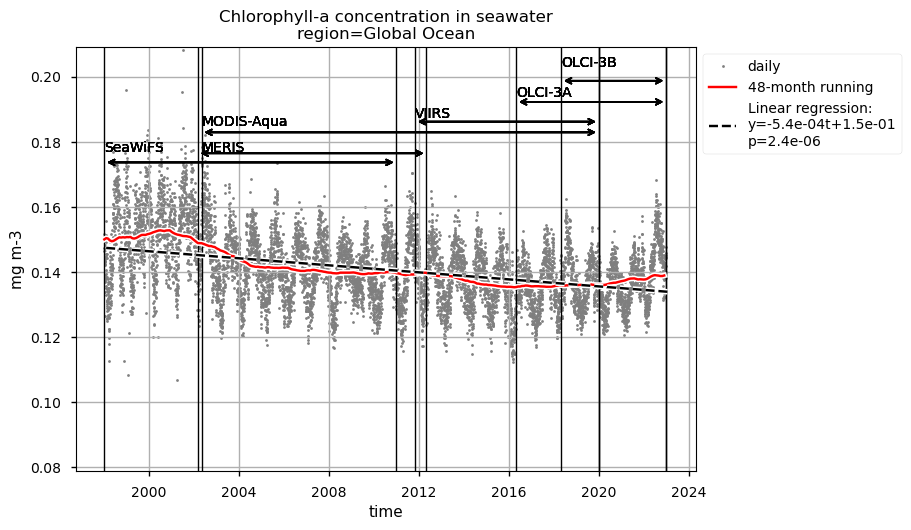

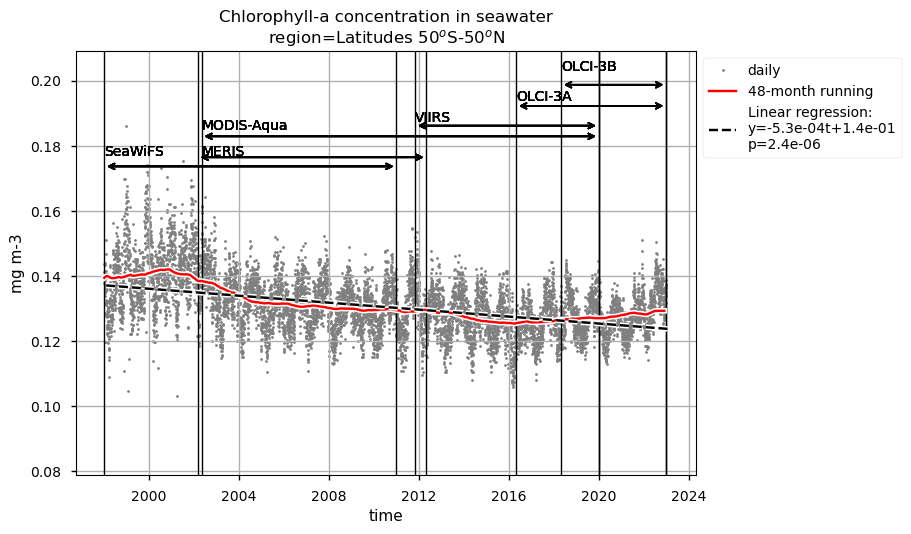

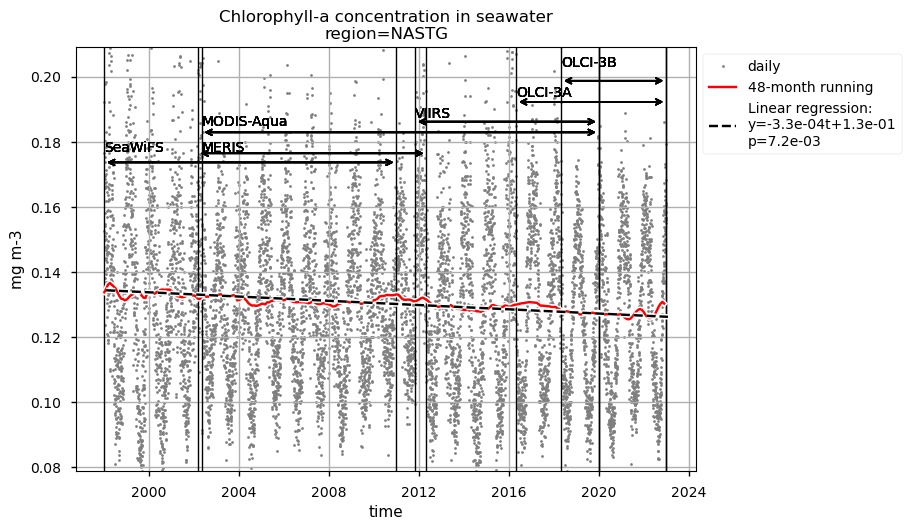

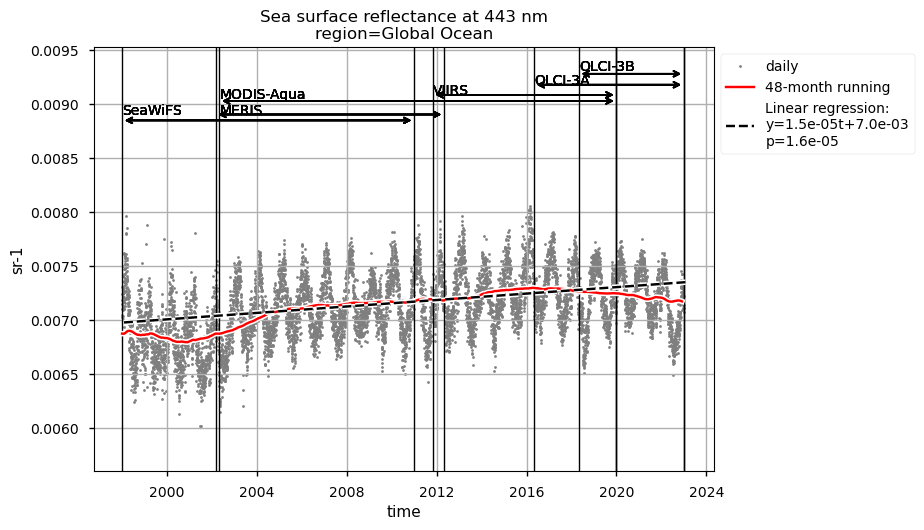

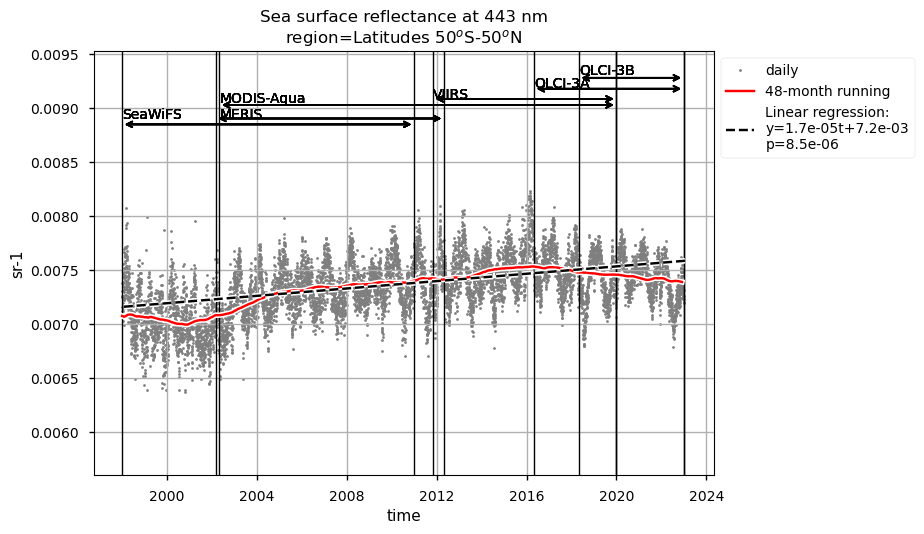

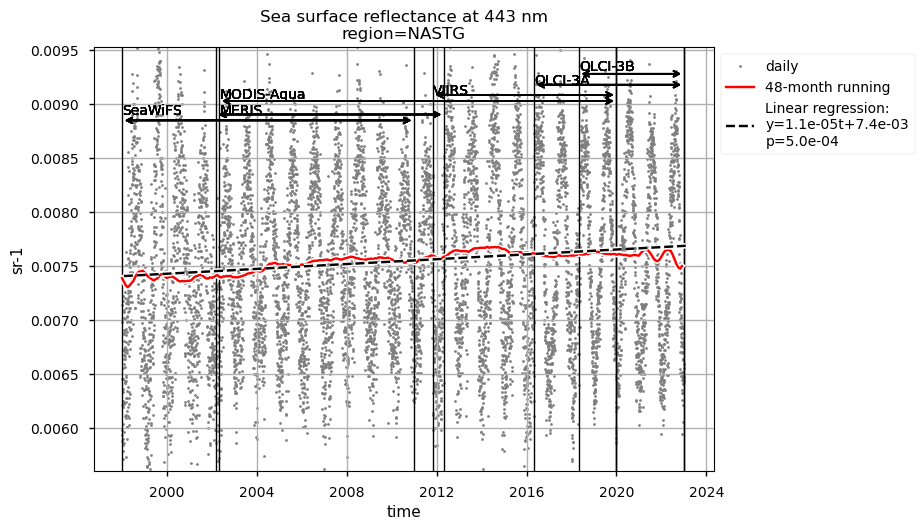

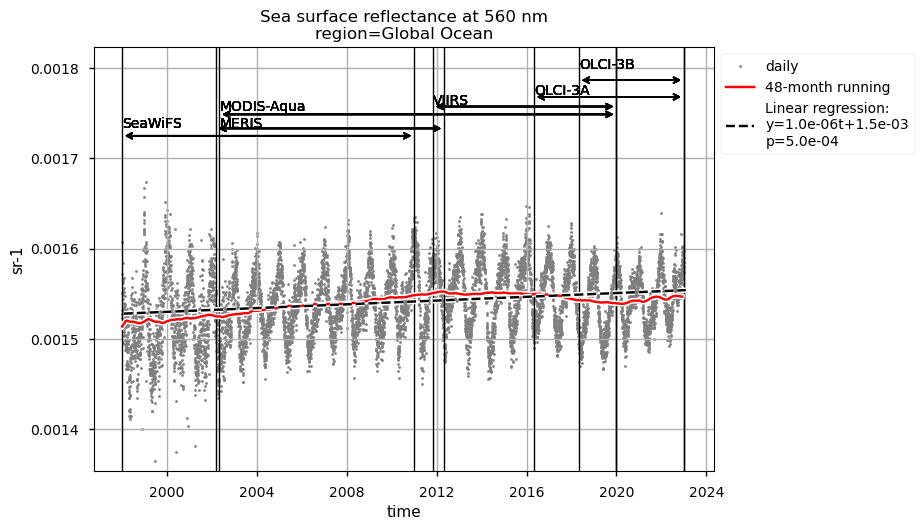

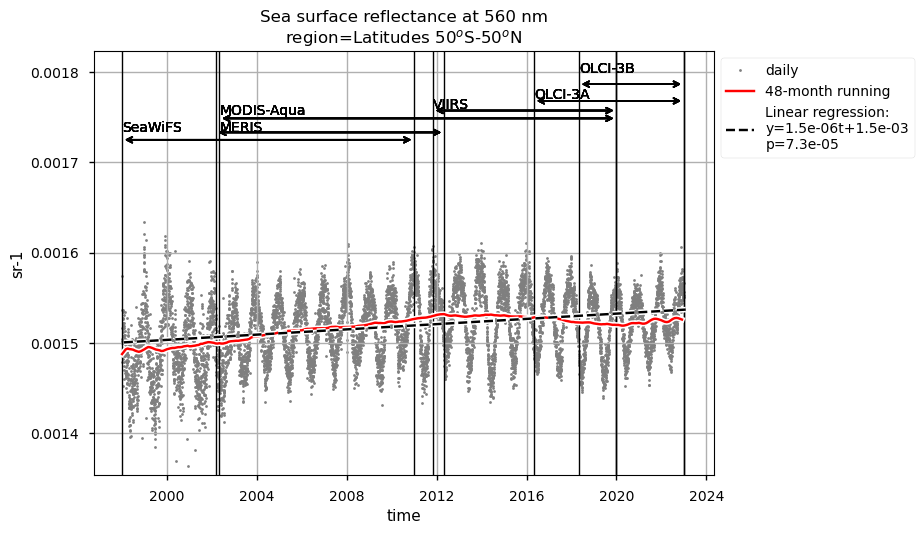

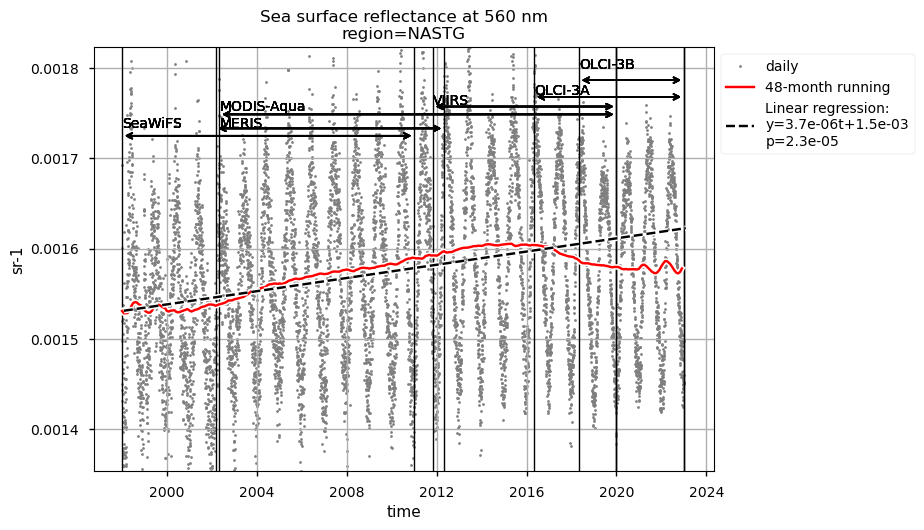

In [7]:
for variable in variables:
    for region in regions:
        fig, ax = plot_timeseries(ds[variable].sel(region=[region]))
        if variable == "chlor_a": 
            ax.set_title(f"Chlorophyll-a concentration in seawater\n{region=:s}")
            ax.set_ylabel("mg m-3")
        if variable == "Rrs_443": 
            ax.set_title(f"Sea surface reflectance at 443 nm\n{region=:s}")
            ax.set_ylabel(f"{ds[variable].attrs['units']}")
        if variable == "Rrs_560": 
            ax.set_title(f"Sea surface reflectance at 560 nm\n{region=:s}")
            ax.set_ylabel(f"{ds[variable].attrs['units']}")
        ax.set_ylim(ds[variable].quantile([0.001, 0.999]).values.tolist())
        for mission_name, mission in missions.items():   
            mission_start = mission['start']
            mission_stop = mission['stop']
            linestyle = mission['linestyle']
            plt.axvline(mission_start, color='black', linestyle=linestyle, lw=1.0)
            plt.axvline(mission_stop, color='black', linestyle=linestyle, lw=1.0)
            plt.annotate('', xy=(np.datetime64('1998-01-01'), ds[variable].quantile(0.981).values), xytext=(np.datetime64('2010-12-31'), ds[variable].quantile(0.981).values), arrowprops=dict(arrowstyle='<->', color='black', lw=1.2))
            plt.annotate('', xy=(np.datetime64('2002-03-01'), ds[variable].quantile(0.985).values), xytext=(np.datetime64('2012-04-30'), ds[variable].quantile(0.985).values), arrowprops=dict(arrowstyle='<->', color='black', lw=1.2))
            plt.annotate('', xy=(np.datetime64('2002-05-01'), ds[variable].quantile(0.991).values), xytext=(np.datetime64('2019-12-31'), ds[variable].quantile(0.991).values), arrowprops=dict(arrowstyle='<->', color='black', lw=1.2))
            plt.annotate('', xy=(np.datetime64('2011-11-01'), ds[variable].quantile(0.993).values), xytext=(np.datetime64('2019-12-31'), ds[variable].quantile(0.993).values), arrowprops=dict(arrowstyle='<->', color='black', lw=1.2))
            plt.annotate('', xy=(np.datetime64('2016-05-01'), ds[variable].quantile(0.995).values), xytext=(np.datetime64('2022-12-31'), ds[variable].quantile(0.995).values), arrowprops=dict(arrowstyle='<->', color='black', lw=1.2))
            plt.annotate('', xy=(np.datetime64('2018-05-01'), ds[variable].quantile(0.997).values), xytext=(np.datetime64('2022-12-31'), ds[variable].quantile(0.997).values), arrowprops=dict(arrowstyle='<->', color='black', lw=1.2))
            plt.text(np.datetime64('1998-01-01'), ds[variable].quantile(0.987).values.tolist(), 'SeaWiFS', ha='left', va='center')
            plt.text(np.datetime64('2002-05-01'), ds[variable].quantile(0.987).values.tolist(), 'MERIS', ha='left', va='center')
            plt.text(np.datetime64('2002-05-01'), ds[variable].quantile(0.993).values.tolist(), 'MODIS-Aqua', ha='left', va='center')
            plt.text(np.datetime64('2011-11-01'), ds[variable].quantile(0.994).values.tolist(), 'VIIRS', ha='left', va='center')
            plt.text(np.datetime64('2016-05-01'), ds[variable].quantile(0.996).values.tolist(), 'OLCI-3A', ha='left', va='center')
            plt.text(np.datetime64('2018-05-01'), ds[variable].quantile(0.998).values.tolist(), 'OLCI-3B', ha='left', va='center')
plt.show()

#### Discussion
Results show that the ESA CCI dataset version 6.0 captures both the seasonal and interannual variability of the ECVs analysed in the three selected regions.  
The largest seasonal variability is found in the NASTG's region, due to the strong seasonal expansion/contraction cycle of the gyre [[6]](https://doi.org/10.1029/2021GL096965). 

**Chlorophyll-a:** Chlorophyll-a trends obtained through a 48-month rolling mean show a maxima around 2002 in both the global ocean and the oceanic region between latitudes 50°S and 50°N, followed by a sharp decrease until 2004. Afterwards, a progressive decrease until around 2015 and a slight increase until 2022 are observed. Chlorophyll-a displays a more constant decreasing trend in the NASTG's region.

**Rrs:** Compared to chlorophyll-a trends, average Rrs at 443 nm shows a reverse pattern in all selected regions.
Rrs at 560 nm trends are rather linear in both the global ocean and the oceanic region between latitudes 50°S and 50°N, while a progressive increase between 1998 and 2017, followed by a rapid decrease until 2022, is observed in the NASTG's region.  

Relatively high chlorophyll-a concentrations and low Rrs at 443 nm are observed when SeaWiFS was the only active satellite (i.e., from January 1998 to March 2002) in all regions except the NASTG's region. 
Overall, these results suggest that, prior to March 2002, Rrs at 443 would be underestimated, especially in more productive oceanic zones, and trigger chlorophyll-a overestimates.    
An additional analysis, performed using the same notebook, but excluding SeaWiFS data prior to March 2002, indicates that they do not significantly modify the long-term trends computed for the ECVs analysed here nor their statistics in all selected regions.

## If you want to know more

#### Key resources
* CDS catalogue entry used in this notebook is the [Ocean colour daily data from 1997 to present derived from satellite observations](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-ocean-colour?tab=overview)
* Data download is from [CDS](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-ocean-colour?tab=form)
* Product Documentation is available on the [CDS](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-ocean-colour?tab=doc) website  
  
<a id="idBopen"></a>
Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`, prepared by [BOpen](https://www.bopen.eu/)

#### References

<a id="idref1"></a>
[[1]](https://doi.org/10.3390/s19194285) Sathyendranath, S., et al. (2019). An Ocean-Colour time series for use in climate studies: the experience of the Ocean-Colour Climate Change Initiative (OC-CCI). Sensors, 19, 4285.

<a id="idref2"></a>
[[2]](https://datastore.copernicus-climate.eu/documents/satellite-ocean-colour/v6.0/WP2-FDDP-2022-04_C3S2-Lot3_PUGS-of-v6.0-OceanColour-product_v1.1_FINAL.pdf) Jackson, T., et al. (2023). C3S Ocean Colour Version 6.0: Product User Guide and Specification. Issue 1.1. E.U. Copernicus Climate Change Service. Document ref. WP2-FDDP-2022-04_C3S2-Lot3_PUGS-of-v6.0-OceanColour-product.  

<a id="idref3"></a>
[[3]](https://aslopubs.onlinelibrary.wiley.com/doi/pdf/10.4319/lo.1997.42.7.1479) Behrenfeld, M.J., & Falkowski, P.G. (1997). A consumer's guide to phytoplankton primary productivity models. Limnology and Oceanography, 42, 1479-1491. 9.

<a id="idref4"></a>
[[4]](https://doi.org/10.1371/journal.pone.0028945) Friedland, K.D., et al. (2012). Pathways between Primary Production and Fisheries Yields of Large Marine Ecosystems. PLoS ONE, 7(1), e28945.  

<a id="idref5"></a>
[[5]](https://datastore.copernicus-climate.eu/documents/satellite-ocean-colour/v6.0/WP2-FDDP-2022-04_C3S2-Lot3_ATBD-of-v6.0-OceanColour-product_v1.1_FINAL.pdf) Jackson, T., et al. (2022). C3S Ocean Colour Version 6.0: Algorithm Theoretical Basis Document. Issue 1.1. E.U. Copernicus Climate Change Service. Document ref. WP2-FDDP-2022-04_C3S2-Lot3_ATBD-of-v6.0-OceanColour-product. 

<a id="idref6"></a>
[[6]](https://doi.org/10.1029/2021GL096965) Leonelli, F.E., et al. (2022). Ultra-oligotrophic waters expansion in the North Atlantic Subtropical Gyre revealed by 21 years of satellite observations. Geophysical Research Letters, 49, e2021GL096965.  

<a id="idref7"></a>
[[7]](https://doi.org/10.1029/95JC00458) Campbell, J.W. (1995). The lognormal distribution as a model for bio-optical variability in the sea. Journal of Geophysical Research, 100, 13237-13254.